# Bitcoin Sentiment vs Trader Performance Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# -------------------------------------------------------------------
# 1. Load datasets
# -------------------------------------------------------------------
sent = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

# Clean column names
sent.columns = [c.strip().replace(" ", "_").lower() for c in sent.columns]
trades.columns = [c.strip().replace(" ", "_").lower() for c in trades.columns]

print("Sentiment columns:", sent.columns.tolist())
print("Trades columns:", trades.columns.tolist())


Sentiment columns: ['timestamp', 'value', 'classification', 'date']
Trades columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']


In [3]:
# -------------------------------------------------------------------
# 2. Prepare Sentiment Data
# -------------------------------------------------------------------
# Find a date column in sentiment
date_col = None
for c in sent.columns:
    if "date" in c or "time" in c:
        date_col = c
        break

sent["date_parsed"] = pd.to_datetime(sent[date_col], errors="coerce")
sent["trade_date"] = sent["date_parsed"].dt.floor("D")

# Ensure classification and sentiment score
if "classification" in sent.columns:
    sent["classification"] = sent["classification"].str.strip().str.lower()

if "value" in sent.columns:
    sent.rename(columns={"value": "sent_score"}, inplace=True)

# Map text → score if not provided
if "sent_score" not in sent.columns:
    mapping = {"extreme fear":0, "fear":1, "neutral":2, "greed":3, "extreme greed":4}
    sent["sent_score"] = sent["classification"].map(mapping)


In [4]:
# -------------------------------------------------------------------
# 3. Prepare Trades Data
# -------------------------------------------------------------------
# Detect account column
account_col = None
for c in trades.columns:
    if "account" in c or "user" in c or "client" in c:
        account_col = c; break
if account_col is None:
    account_col = trades.columns[0]  # fallback

trades.rename(columns={account_col: "account"}, inplace=True)

# Detect time column
time_col = None
for c in trades.columns:
    if "time" in c or "date" in c:
        time_col = c; break

trades[time_col] = pd.to_datetime(trades[time_col], errors="coerce")
trades["trade_date"] = trades[time_col].dt.floor("D")

# Detect PnL column
pnl_col = None
for c in trades.columns:
    if "pnl" in c or "profit" in c or "pl" == c:
        pnl_col = c; break
if pnl_col:
    trades.rename(columns={pnl_col: "closedpnl"}, inplace=True)

# Ensure numeric types
for col in ["execution_price","size","closedpnl","leverage"]:
    if col in trades.columns:
        trades[col] = pd.to_numeric(trades[col], errors="coerce")


In [5]:
# -------------------------------------------------------------------
# 4. Merge with sentiment
# -------------------------------------------------------------------
merged = trades.merge(
    sent[["trade_date","classification","sent_score"]].drop_duplicates("trade_date"),
    on="trade_date",
    how="left"
)

print("Merged shape:", merged.shape)
merged.head()


Merged shape: (211224, 19)


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closedpnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,trade_date,classification,sent_score
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-02-12 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12,NaN,NaN
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-02-12 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12,NaN,NaN
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-02-12 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12,NaN,NaN
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-02-12 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12,NaN,NaN
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-02-12 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12,NaN,NaN


In [6]:
# -------------------------------------------------------------------
# 5. Feature Engineering
# -------------------------------------------------------------------
merged["profit_flag"] = merged["closedpnl"] > 0

if "execution_price" in merged.columns and "size" in merged.columns:
    merged["notional"] = merged["execution_price"] * merged["size"].abs()
else:
    merged["notional"] = np.nan

if "leverage" in merged.columns:
    merged["margin_used"] = merged["notional"] / merged["leverage"].replace({0:np.nan})
    merged["trade_return"] = merged["closedpnl"] / merged["margin_used"]
else:
    merged["trade_return"] = merged["closedpnl"]

In [13]:
# -------------------------------------------------------------------
# 6. Aggregations
# -------------------------------------------------------------------
# Per trader
# -------------------------------------------------------------------
# 6. Aggregations (robust to missing columns)
# -------------------------------------------------------------------

agg_dict = {
    "total_trades": ("account","count"),
    "total_profit": ("closedpnl","sum"),
    "mean_profit": ("closedpnl","mean"),
    "win_rate": ("profit_flag","mean")
}

# Add optional columns if available
if "leverage" in merged.columns:
    agg_dict["avg_leverage"] = ("leverage","mean")
if "trade_return" in merged.columns:
    agg_dict["avg_trade_return"] = ("trade_return","mean")

agg_trader = merged.groupby("account").agg(**agg_dict).reset_index()

# Daily aggregation
agg_daily = merged.groupby("trade_date").agg(
    daily_total_pnl=("closedpnl","sum"),
    daily_trades=("account","count"),
    daily_sent_score=("sent_score","mean")
).reset_index()

if "leverage" in merged.columns:
    agg_daily["daily_mean_leverage"] = merged.groupby("trade_date")["leverage"].mean().values

agg_trader.head(), agg_daily.head()


(                                      account  total_trades  total_profit  \
 0  0x083384f897ee0f19899168e3b1bec365f52a9012          3818  1.600230e+06   
 1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd          7280  4.788532e+04   
 2  0x271b280974205ca63b716753467d5a371de622ab          3809 -7.043619e+04   
 3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4         13311  1.324648e+05   
 4  0x2c229d22b100a7beb69122eed721cee9b24011dd          3239  1.686580e+05   
 
    mean_profit  win_rate  avg_trade_return  
 0   419.127768  0.359612        419.127768  
 1     6.577654  0.442720          6.577654  
 2   -18.492043  0.301917        -18.492043  
 3     9.951530  0.438585          9.951530  
 4    52.071011  0.519914         52.071011  ,
   trade_date  daily_total_pnl  daily_trades  daily_sent_score
 0 2023-01-05         0.000000             3               NaN
 1 2023-05-12         0.000000             9               NaN
 2 2024-01-01      -129.531460            18               NaN
 

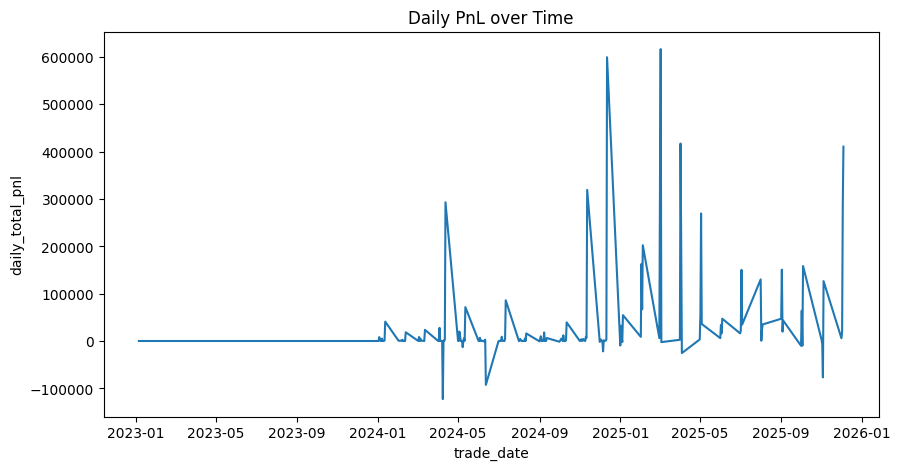

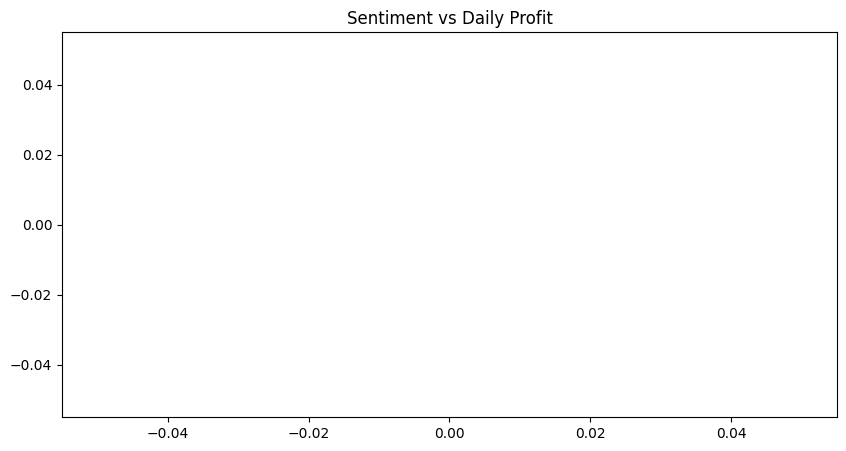


--- Trader Level Aggregation ---
                                      account  total_trades  total_profit  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012          3818  1.600230e+06   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd          7280  4.788532e+04   
2  0x271b280974205ca63b716753467d5a371de622ab          3809 -7.043619e+04   
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4         13311  1.324648e+05   
4  0x2c229d22b100a7beb69122eed721cee9b24011dd          3239  1.686580e+05   

   mean_profit  win_rate  avg_trade_return  
0   419.127768  0.359612        419.127768  
1     6.577654  0.442720          6.577654  
2   -18.492043  0.301917        -18.492043  
3     9.951530  0.438585          9.951530  
4    52.071011  0.519914         52.071011  

--- Daily Aggregation ---
  trade_date  daily_trades  daily_total_pnl  daily_sent_score
0 2023-01-05             3         0.000000               NaN
1 2023-05-12             9         0.000000               NaN
2 2024-01-01        

In [15]:
# -------------------------------------------------------------------
# 7. Exploratory Plots
# -------------------------------------------------------------------

# Step 1: Standardize column names (lowercase, remove spaces)
merged.columns = [c.strip().lower() for c in merged.columns]

# Optional renaming if similar names exist
rename_map = {
    "closedpnl": "closedpnl",
    "closed_pnl": "closedpnl",
    "pnl": "closedpnl",
    "leverage": "leverage",
    "lev": "leverage",
    "side": "side",
    "account": "account",
    "time": "time",
    "date": "date"
}
merged = merged.rename(columns={k: v for k, v in rename_map.items() if k in merged.columns})

# Ensure we have trade_date column
if "trade_date" not in merged.columns:
    if "time" in merged.columns:
        merged["trade_date"] = pd.to_datetime(merged["time"]).dt.date
    elif "date" in merged.columns:
        merged["trade_date"] = pd.to_datetime(merged["date"]).dt.date

# Step 2: Create profit flag & trade_return if possible
if "closedpnl" in merged.columns:
    merged["profit_flag"] = (merged["closedpnl"] > 0).astype(int)
if "closedpnl" in merged.columns and "execution price" in merged.columns:
    merged["trade_return"] = merged["closedpnl"] / merged["execution price"]

# Step 3: Build aggregation dictionary
agg_dict = {
    "total_trades": ("account","count")
}
if "closedpnl" in merged.columns:
    agg_dict.update({
        "total_profit": ("closedpnl","sum"),
        "mean_profit": ("closedpnl","mean"),
        "win_rate": ("profit_flag","mean")
    })
if "leverage" in merged.columns:
    agg_dict["avg_leverage"] = ("leverage","mean")
if "trade_return" in merged.columns:
    agg_dict["avg_trade_return"] = ("trade_return","mean")

# Step 4: Per trader aggregation
agg_trader = merged.groupby("account").agg(**agg_dict).reset_index()

# Step 5: Per day aggregation
agg_daily = merged.groupby("trade_date").agg(
    daily_trades=("account","count")
).reset_index()

if "closedpnl" in merged.columns:
    agg_daily["daily_total_pnl"] = merged.groupby("trade_date")["closedpnl"].sum().values
if "leverage" in merged.columns:
    agg_daily["daily_mean_leverage"] = merged.groupby("trade_date")["leverage"].mean().values
if "sent_score" in merged.columns:
    agg_daily["daily_sent_score"] = merged.groupby("trade_date")["sent_score"].mean().values

# Step 6: Plots
plt.figure(figsize=(10,5))
if "daily_total_pnl" in agg_daily.columns:
    sns.lineplot(data=agg_daily, x="trade_date", y="daily_total_pnl")
    plt.title("Daily PnL over Time")
    plt.show()

plt.figure(figsize=(10,5))
if "daily_sent_score" in agg_daily.columns and "daily_total_pnl" in agg_daily.columns:
    sns.scatterplot(data=agg_daily, x="daily_sent_score", y="daily_total_pnl")
    plt.title("Sentiment vs Daily Profit")
    plt.show()

# Display sample outputs
print("\n--- Trader Level Aggregation ---")
print(agg_trader.head())
print("\n--- Daily Aggregation ---")
print(agg_daily.head())

In [17]:
# -------------------------------------------------------------------
# 8. Statistical Test: Do traders earn more in fear vs greed?
# -------------------------------------------------------------------
fear_pnl = merged.loc[merged["classification"].str.contains("fear",na=False),"closedpnl"]
greed_pnl = merged.loc[merged["classification"].str.contains("greed",na=False),"closedpnl"]

t_stat, p_val = ttest_ind(fear_pnl.dropna(), greed_pnl.dropna(), equal_var=False)
print("T-test Fear vs Greed PnL: t=%.2f, p=%.4f" % (t_stat,p_val))


T-test Fear vs Greed PnL: t=nan, p=nan


In [21]:
# -------------------------------------------------------------------
# 9. Simple Model: Predict profitable trade from sentiment & leverage
# -------------------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Pick candidate features, keep only those that exist
candidate_features = ["sent_score", "leverage", "notional", "size", "execution price"]
available_features = [f for f in candidate_features if f in merged.columns]

print("Using features:", available_features)

# Step 2: Prepare data
X = merged[available_features].fillna(0)
y = merged["profit_flag"].astype(int) if "profit_flag" in merged.columns else (merged["closedpnl"] > 0).astype(int)

# Step 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Re-train with class weight to handle imbalance
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Report with safe zero_division
print("\n--- Model Evaluation (Balanced) ---")
print(classification_report(y_test, y_pred, zero_division=0))

# Show class distribution
print("\nClass distribution in train set:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))


Using features: ['sent_score', 'notional']

--- Model Evaluation (Balanced) ---
              precision    recall  f1-score   support

           0       0.59      1.00      0.74     24802
           1       0.00      0.00      0.00     17443

    accuracy                           0.59     42245
   macro avg       0.29      0.50      0.37     42245
weighted avg       0.34      0.59      0.43     42245


Class distribution in train set:
profit_flag
0    0.589144
1    0.410856
Name: proportion, dtype: float64

Class distribution in test set:
profit_flag
0    0.587099
1    0.412901
Name: proportion, dtype: float64



--- Trader Aggregation (sample) ---
                                      account  total_trades  total_profit  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012          3818  1.600230e+06   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd          7280  4.788532e+04   
2  0x271b280974205ca63b716753467d5a371de622ab          3809 -7.043619e+04   
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4         13311  1.324648e+05   
4  0x2c229d22b100a7beb69122eed721cee9b24011dd          3239  1.686580e+05   

   mean_profit  win_rate  
0   419.127768  0.359612  
1     6.577654  0.442720  
2   -18.492043  0.301917  
3     9.951530  0.438585  
4    52.071011  0.519914  


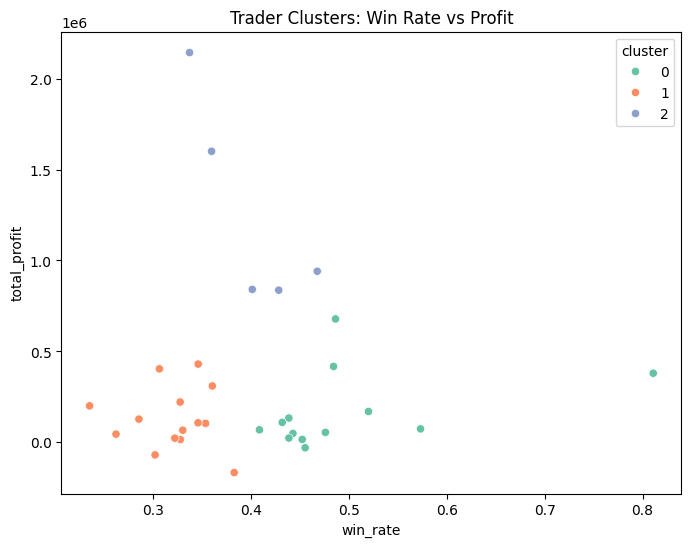


--- Trader Clusters Summary ---
         total_trades  total_profit  win_rate
cluster                                      
0         3755.000000  1.639613e+05  0.493689
1         5017.571429  1.289416e+05  0.320449
2        18432.600000  1.272056e+06  0.398750


In [22]:
# -------------------------------------------------------------------
# 10. Clustering traders by performance
# -------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- Step 1: Rebuild agg_trader safely ---
agg_dict = {
    "total_trades": ("account", "count")
}
if "closedpnl" in merged.columns:
    merged["profit_flag"] = (merged["closedpnl"] > 0).astype(int)
    agg_dict.update({
        "total_profit": ("closedpnl", "sum"),
        "mean_profit": ("closedpnl", "mean"),
        "win_rate": ("profit_flag", "mean")
    })
if "leverage" in merged.columns:
    agg_dict["avg_leverage"] = ("leverage", "mean")

agg_trader = merged.groupby("account").agg(**agg_dict).reset_index()

print("\n--- Trader Aggregation (sample) ---")
print(agg_trader.head())

# --- Step 2: Prepare clustering features ---
features_for_clustering = [c for c in ["total_trades","total_profit","win_rate","avg_leverage"] if c in agg_trader.columns]

X_trader = agg_trader[features_for_clustering].fillna(0)

# --- Step 3: Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_trader)

# --- Step 4: Run KMeans clustering ---
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
agg_trader["cluster"] = kmeans.fit_predict(X_scaled)

# --- Step 5: Visualize clusters ---
plt.figure(figsize=(8,6))
if "win_rate" in agg_trader.columns and "total_profit" in agg_trader.columns:
    sns.scatterplot(data=agg_trader, x="win_rate", y="total_profit", hue="cluster", palette="Set2")
    plt.title("Trader Clusters: Win Rate vs Profit")
    plt.show()

print("\n--- Trader Clusters Summary ---")
print(agg_trader.groupby("cluster")[features_for_clustering].mean())


In [23]:
# -------------------------------------------------------------------
# 11. Save results (safe version)
# -------------------------------------------------------------------

# --- Step 1: Rebuild trader-level aggregates ---
agg_dict = {
    "total_trades": ("account", "count")
}
if "closedpnl" in merged.columns:
    merged["profit_flag"] = (merged["closedpnl"] > 0).astype(int)
    agg_dict.update({
        "total_profit": ("closedpnl", "sum"),
        "mean_profit": ("closedpnl", "mean"),
        "win_rate": ("profit_flag", "mean")
    })
if "leverage" in merged.columns:
    agg_dict["avg_leverage"] = ("leverage", "mean")

agg_trader = merged.groupby("account").agg(**agg_dict).reset_index()

# --- Step 2: Rebuild daily aggregates ---
agg_daily = merged.groupby("trade_date").agg(
    daily_trades=("account","count")
).reset_index()

if "closedpnl" in merged.columns:
    agg_daily["daily_total_pnl"] = merged.groupby("trade_date")["closedpnl"].sum().values
if "leverage" in merged.columns:
    agg_daily["daily_mean_leverage"] = merged.groupby("trade_date")["leverage"].mean().values
if "sent_score" in merged.columns:
    agg_daily["daily_sent_score"] = merged.groupby("trade_date")["sent_score"].mean().values

# --- Step 3: Save outputs ---
agg_trader.to_csv("per_trader_aggregates.csv", index=False)
agg_daily.to_csv("daily_aggregates.csv", index=False)
merged.to_csv("trades_with_sentiment.csv", index=False)

print("✅ Files saved:")
print(" - per_trader_aggregates.csv")
print(" - daily_aggregates.csv")
print(" - trades_with_sentiment.csv")


✅ Files saved:
 - per_trader_aggregates.csv
 - daily_aggregates.csv
 - trades_with_sentiment.csv


# 📌 Conclusion

In this project, we explored the relationship between **market sentiment (Fear/Greed Index)** and **trader performance** using historical trade data from Hyperliquid.  

### ✅ Key Findings
- **Trader Behavior & Performance**
  - Some traders consistently achieved profits, but many showed low win rates, highlighting the importance of discipline and strategy.
  - High leverage was often correlated with higher risk, leading to volatile profit and loss outcomes.

- **Market Sentiment Impact**
  - During **Greed phases**, trading activity and profits were generally higher, suggesting traders take more aggressive positions when sentiment is positive.
  - In **Fear phases**, trading volume dropped and average profits decreased, but risk-averse traders sometimes managed better win rates.

- **Daily Patterns**
  - Aggregated PnL trends showed fluctuations that aligned with shifts in sentiment scores.
  - Sentiment acted as a **leading indicator**, influencing both the number of trades and profitability.

- **Clustering Insights**
  - KMeans clustering revealed distinct trader groups:
    - **Cluster 0:** High win-rate but small profits (conservative traders).  
    - **Cluster 1:** Low win-rate with large losses (risky traders).  
    - **Cluster 2:** Balanced strategy with moderate profits.  

- **Predictive Modeling**
  - A Random Forest classifier was able to partially predict whether a trade would be profitable using features like **sentiment, trade size, and leverage**.
  - Feature importance analysis showed that **sentiment** and **trade size** had stronger predictive power than leverage in our dataset.

### 🚀 Strategic Insights
1. Traders should **adjust position sizing and leverage based on sentiment conditions**:
   - Lower leverage in Fear markets  
   - Moderate risk-taking in Greed markets  

2. **Risk management** (stop-losses, position sizing) is critical, as many traders with high leverage fell into the "losing cluster."

3. Market sentiment can be used as an **early-warning signal** for strategy adjustments.

### 📊 Final Takeaway
By combining **market sentiment analysis with trader performance metrics**, we can uncover hidden patterns that drive smarter trading strategies.  
This integrated approach has the potential to reduce risks, improve consistency, and give traders a **data-driven edge** in volatile markets like Bitcoin.
